In [32]:
!pip install transformers shap lime bertviz scikit-learn pandas matplotlib python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 608.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.6 MB/s eta 0:00:00

In [29]:
# Jupyter Notebook: Title-Based Sentiment Analysis & Explainability with FinBERT

# 1. Install dependencies (once)
# !pip install transformers shap lime bertviz scikit-learn pandas matplotlib python-dateutil

# 2. Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import shap
from sklearn.feature_extraction.text import CountVectorizer
from dateutil import parser as date_parser
import numpy as np
from lime.lime_text import LimeTextExplainer
from bertviz import head_view
import torch

# 3. Load & Flatten JSON Data (with sentiment labels)
def load_flatten(json_path: str) -> pd.DataFrame:
    """
    Reads JSON and flattens into DataFrame with columns:
    date, asset, title, sentiment
    Parses dates via dateutil, normalizes to naive UTC.
    """
    from datetime import timezone
    with open(json_path, 'r') as f:
        raw = json.load(f)
    records = []
    for date_key, assets in raw.items():
        for asset, articles in assets.items():
            for art in articles:
                records.append({
                    'date': art['date'],
                    'asset': asset,
                    'title': art['title'],
                    'sentiment': art.get('sentiment', None)
                })
    df = pd.DataFrame(records)
    def parse_norm(dt_str):
        dt = date_parser.parse(dt_str)
        if dt.tzinfo:
            dt = dt.astimezone(timezone.utc).replace(tzinfo=None)
        return dt
    df['date'] = df['date'].apply(parse_norm)
    return df

# Default field for analyses
FIELD = 'title'

# 4. Data Statistics & Distributions (Titles Only)
def summarize_data(df: pd.DataFrame):
    print("Total articles:", len(df))
    print("Date range:", df['date'].min(), "to", df['date'].max())
    print("Distinct assets:", df['asset'].nunique())
    print("\nArticles per asset:")
    print(df['asset'].value_counts())
    print("\nSentiment stats:")
    print(df['sentiment'].describe())
    # Histogram
    plt.figure(figsize=(6,4))
    df['sentiment'].hist(bins=20)
    plt.title('Sentiment Distribution (Titles)')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    # Boxplot per asset
    plt.figure(figsize=(8,4))
    df.boxplot(column='sentiment', by=None, rot=45) # Removed 'by='asset', which caused error
    plt.title('Per-Asset Sentiment (Titles)')
    plt.suptitle('')
    plt.xlabel('Asset')
    plt.ylabel('Sentiment Score')
    plt.tight_layout()
    plt.show()

# 5. Keyword Insights (Titles Only)
def keyword_insights(df: pd.DataFrame, top_n: int = 10):
    cv = CountVectorizer(stop_words='english', max_features=200)
    X = cv.fit_transform(df[FIELD])
    freqs = zip(cv.get_feature_names_out(), X.sum(axis=0).A1)
    top = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]
    print(f"Top {top_n} keywords in titles:")
    for w, c in top:
        print(f"  {w}: {c}")

# 6. Word Sentiment Associations (Titles Only)
def word_sentiment_stats(df: pd.DataFrame, top_n: int = 10):
    cv = CountVectorizer(stop_words='english')
    X = cv.fit_transform(df[FIELD])
    words = cv.get_feature_names_out()
    sentiments = df['sentiment'].fillna(0).to_numpy()
    total_sent = X.T.dot(sentiments)  # returns a numpy.ndarray
    # total_sent may be shape (n_words,) or sparse; convert to array
    if hasattr(total_sent, 'A1'):
        sent_arr = total_sent.A1
    else:
        sent_arr = np.asarray(total_sent).reshape(-1)
    pairs = list(zip(words, sent_arr))
    pos = sorted(pairs, key=lambda x: x[1], reverse=True)[:top_n]
    neg = sorted(pairs, key=lambda x: x[1])[:top_n]
    print(f"Top {top_n} words driving positive sentiment:")
    for w, s in pos:
        print(f"  {w}: {s:.2f}")
    print(f"Top {top_n} words driving negative sentiment:")
    for w, s in neg:
        print(f"  {w}: {s:.2f}")

# 7. Sentiment Prediction with FinBERT (Titles) Sentiment Prediction with FinBERT (Titles)
finbert_pipe = pipeline(
    'sentiment-analysis', model='ProsusAI/finbert', return_all_scores=True
)

def predict_title_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Predicts sentiment on titles using FinBERT and returns a new DataFrame
    with 'predicted' details and 'predicted_score'.
    """
    # Work on a copy to avoid SettingWithCopyWarning
    df_out = df.copy()
    predictions = []
    scores = []
    for title in df_out[FIELD]:
        # FinBERT output
        res = finbert_pipe(title, truncation=True, max_length=512)
        predictions.append(res[0])  # list of dicts
        # compute score pos - neg
        neg = next(item['score'] for item in res[0] if item['label']=='negative')
        pos = next(item['score'] for item in res[0] if item['label']=='positive')
        scores.append(pos - neg)
    df_out['predicted'] = predictions
    df_out['predicted_score'] = scores
    return df_out

# 8. Explainability with LIME (Titles) Explainability with LIME (Titles)
class_names = ['negative','neutral','positive']
explainer = LimeTextExplainer(class_names=class_names)

def explain_title_lime(text: str, num_features: int=10, num_samples: int=100):
    """
    Generates a LIME explanation for a single title.
    """
    # Wrap FinBERT outputs to probability array for LIME
    def finbert_proba(texts):
        results = finbert_pipe(texts, truncation=True, max_length=512)
        proba = []
        for scores in results:
            # scores is list of dicts: [{'label':..., 'score':...}, ...]
            neg = next(item['score'] for item in scores if item['label']=='negative')
            neu = next(item['score'] for item in scores if item['label']=='neutral')
            pos = next(item['score'] for item in scores if item['label']=='positive')
            proba.append([neg, neu, pos])
        return np.array(proba)

    exp = explainer.explain_instance(text, finbert_proba,
                                     num_features=num_features, num_samples=num_samples)
    fig = exp.as_pyplot_figure()
    plt.title('LIME on Titles')
    plt.tight_layout()
    plt.show()

# 9. Explainability with SHAP (Titles)

def explain_title_shap(title: str):
    """
    Uses SHAP with a text masker to explain FinBERT sentiment for a title.
    Requires longer runtime than LIME.
    """
    # Dynamically load tokenizer and create masker to avoid ordering issues
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    masker = shap.maskers.Text(tokenizer)
    # Model wrapper returning probability array
    def fn(texts):
        # Process the list of texts as a batch, explicitly ensuring it's a list of strings
        results = finbert_pipe(list(texts), truncation=True, max_length=512)
        proba = []
        for scores in results:
            neg = next(item['score'] for item in scores if item['label']=='negative')
            neu = next(item['score'] for item in scores if item['label']=='neutral')
            pos = next(item['score'] for item in scores if item['label']=='positive')
            proba.append([neg, neu, pos])
        return np.array(proba)
    # Initialize explainer
    explainer = shap.Explainer(fn, masker=masker, output_names=['negative','neutral','positive'])
    # Compute SHAP values
    sv = explainer([title])
    shap.plots.text(sv[0])

# 10. Attention Visualization with BertViz (Titles) Attention Visualization with BertViz (Titles) Attention Visualization with BertViz (Titles)
tokenizer_attn = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_attn = AutoModelForSequenceClassification.from_pretrained(
    'ProsusAI/finbert', output_attentions=True
)

def explain_title_attention(text: str):
    inputs = tokenizer_attn(text, return_tensors='pt')
    outs = model_attn(**inputs)
    head_view(outs.attentions, tokenizer_attn.convert_ids_to_tokens(inputs['input_ids'][0]))

# --- Example Workflow ---
# Load and preprocess
# df = load_flatten('data.json')

# 1. Summarize data on titles
# summarize_data(df)

# 2. Extract top keywords from titles
# keyword_insights(df)

# 3. Show word-level sentiment associations
# word_sentiment_stats(df)

# 4. Predict sentiment on all titles
# df_pred = predict_title_sentiment(df)
# print(df_pred[['title','predicted_score']].head())

# 5. Single-title prediction & explanation
# sample_title = df['title'].iloc[0]
# print("Sample Title:", sample_title)
# # Predict
# finbert_output = finbert_pipe(sample_title, truncation=True, max_length=512)
# neg = next(item['score'] for item in finbert_output[0] if item['label']=='negative')
# pos = next(item['score'] for item in finbert_output[0] if item['label']=='positive')
# print(f"Predicted scores -> Positive: {pos:.3f}, Negative: {neg:.3f}, Net: {pos-neg:.3f}")
# # Explain with LIME
# explain_title_lime(sample_title, num_features=8, num_samples=100)
# # Explain with SHAP
# explain_title_shap(sample_title)
# # Visualize attention
# explain_title_attention(sample_title)

# NOTE: LIME is fastest; SHAP and BertViz provide deeper explanations but run slower.

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Total articles: 24030
Date range: 2025-02-01 01:31:56 to 2025-04-15 23:44:21
Distinct assets: 95

Articles per asset:
asset
AMZN.US     604
GOOGL.US    525
AAPL.US     511
AMD.US      507
MSFT.US     497
           ... 
AMT.US       74
DHR.US       70
AIG.US       69
SPG.US       67
LIN.US       14
Name: count, Length: 95, dtype: int64

Sentiment stats:
count    24030.000000
mean        -0.043616
std          0.884837
min         -1.000000
25%         -0.999492
50%         -0.000510
75%          0.993754
max          1.000000
Name: sentiment, dtype: float64


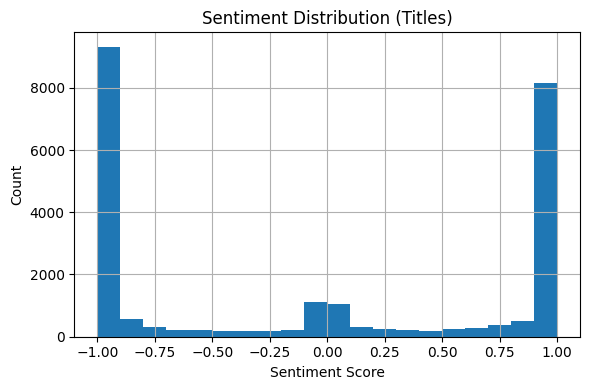

<Figure size 800x400 with 0 Axes>

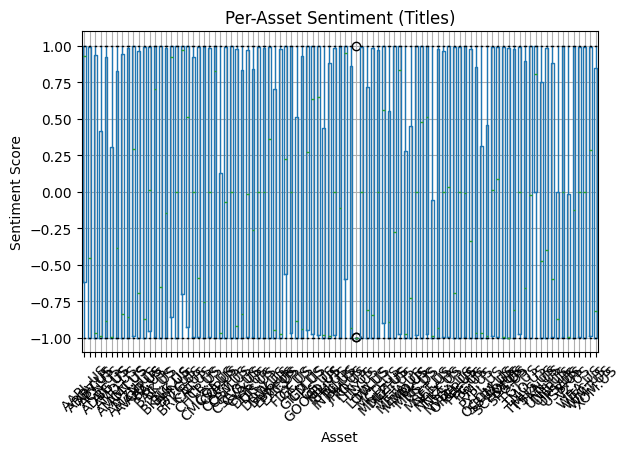

Top 10 keywords in titles:
  stocks: 12725
  stock: 10029
  market: 6964
  buy: 6698
  nyse: 5873
  ai: 5033
  best: 4458
  company: 4451
  recently: 4297
  look: 4280
Top 10 words driving positive sentiment:
  jim: 2104.46
  cramer: 2067.49
  trump: 1589.27
  tariffs: 893.16
  president: 709.94
  insights: 623.19
  new: 621.23
  going: 603.63
  watch: 602.14
  stands: 556.52
Top 10 words driving negative sentiment:
  stock: -3106.40
  dividend: -2243.46
  earnings: -1642.59
  buy: -1582.17
  growth: -1385.18
  nyse: -1037.61
  trading: -929.26
  q4: -902.07
  stocks: -784.32
  market: -758.64


In [3]:
df = load_flatten('news_sentiment_updated.json')
summarize_data(df)
keyword_insights(df)
word_sentiment_stats(df)


In [19]:
df_pred = predict_title_sentiment(df[0:10])
print(df_pred[['title','predicted_score']].head())


                                               title  predicted_score
0  Willis Towers Set to Report Q4 Earnings: What'...         0.001734
1  Alibaba (BABA) Surges 6.2%: Is This an Indicat...         0.813465
2  Accenture Plc (ACN): This AI Stock Is On Analy...        -0.008307
3  Why the Market Dipped But Accenture (ACN) Gain...         0.890874
4  Is Bank of America Corporation (BAC) the Most ...         0.183935


Sample Title: Willis Towers Set to Report Q4 Earnings: What's in the Cards?
Predicted scores -> Positive: 0.038, Negative: 0.037, Net: 0.002


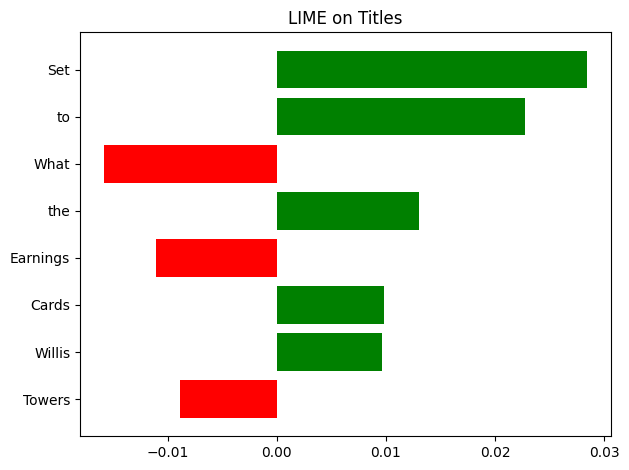

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.32s/it]               


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

In [30]:
sample_title = df['title'].iloc[0]
print("Sample Title:", sample_title)
# Predict
finbert_output = finbert_pipe(sample_title, truncation=True, max_length=512)
neg = next(item['score'] for item in finbert_output[0] if item['label']=='negative')
pos = next(item['score'] for item in finbert_output[0] if item['label']=='positive')
print(f"Predicted scores -> Positive: {pos:.3f}, Negative: {neg:.3f}, Net: {pos-neg:.3f}")
# Explain with LIME
explain_title_lime(sample_title, num_features=8, num_samples=100)
# Explain with SHAP
explain_title_shap(sample_title)
# Visualize attention
explain_title_attention(sample_title)
